# 1. Configuración de ambiente

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3800k      0 --:--:-- --:--:-- --:--:-- 3805k


# 2. Obtención, Tratamineto y Análisis Exploratorio (EDA)

In [2]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [5]:
df_movies.dtypes

,0
movieId,int64
title,object
genres,object


In [6]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.00,1493848402
100832,610,168248,5.00,1493850091
100833,610,168250,5.00,1494273047
100834,610,168252,5.00,1493846352
100835,610,170875,3.00,1493846415


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836.00
mean,326.13,19435.30,3.50,1205946087.37
std,182.62,35530.99,1.04,216261036.00
min,1.00,1.00,0.50,828124615.00
25%,177.00,1199.00,3.00,1019123866.00
50%,325.00,2991.00,3.50,1186086662.00
75%,477.00,8122.00,4.00,1435994144.50
max,610.00,193609.00,5.00,1537799250.00


In [9]:
df_ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


# 3. Tratamiento de datos

In [10]:
def preprocesamiento():
  global df_movies, df_ratings

  # No observamos nulos en ninguno de los dos dataframe

  # Eliminamos duplicados en df_movies, teniendo movieId como llave
  df_movies = df_movies.drop_duplicates(subset=['movieId'])

  # Eliminamos duplicados en df_ratings, teniendo movieId y userId como llave
  df_ratings = df_ratings.drop_duplicates(subset=['movieId','userId'])

  # Creamos la columna 'content'
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ')

  # Creamos la columna 'genre_set' en df_movies como un conjunto de géneros
  df_movies['genres_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

  # Cambiamos el tipo de dato de 'timestamp'
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

preprocesamiento()

In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     9742 non-null   int64 
 1   title       9742 non-null   object
 2   genres      9742 non-null   object
 3   content     9742 non-null   object
 4   genres_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


In [12]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [13]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [14]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


In [15]:
df_ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,datetime64[ns]


# Análisis exploratorio (EDA)

timestamp:

Importancia: Indica cuándo se realizó la calificación. Si deseas explorar cómo las preferencias de los usuarios han cambiado con el tiempo, este atributo es clave. Puede ser usado para análisis temporales o para crear features temporales adicionales.
Análisis sugerido: Series temporales para observar tendencias a lo largo del tiempo.

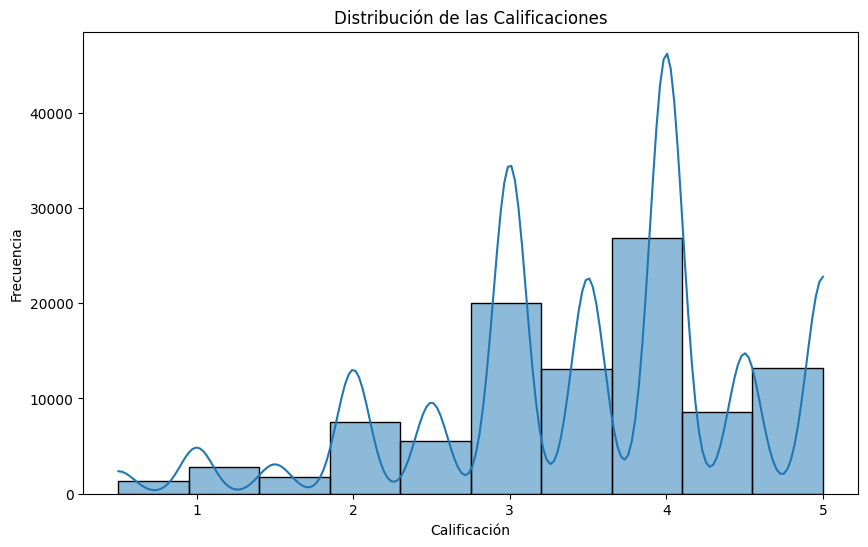

In [16]:
# Histograma de la distribución de las calificaciones
plt.figure(figsize=(10,6))
sns.histplot(df_ratings['rating'], bins=10, kde=True)
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

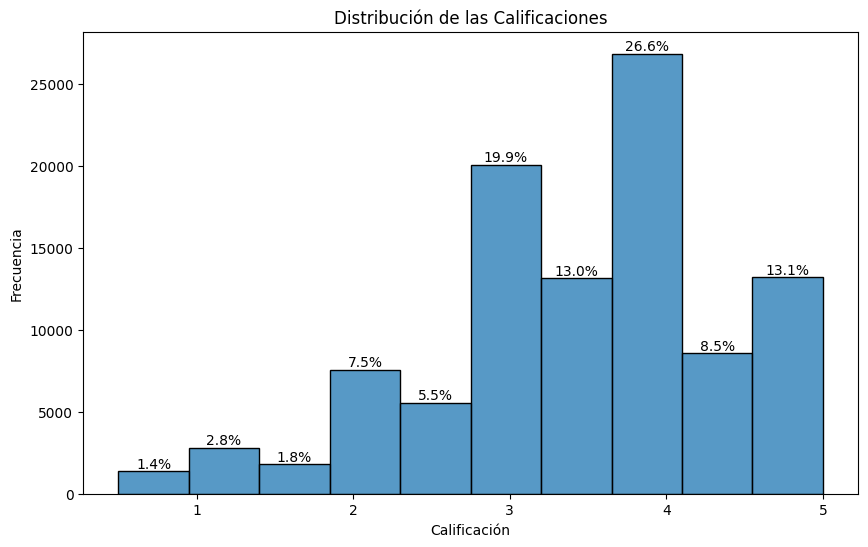

In [17]:
# Histograma de la distribución de las calificaciones
plt.figure(figsize=(10,6))

# Crear el histograma sin la línea de densidad
ax = sns.histplot(df_ratings['rating'], bins=10)

# Calcular el total de observaciones
total = len(df_ratings['rating'])

# Iterar sobre los contenedores (bars) para calcular y colocar los porcentajes
for p in ax.patches:
    height = p.get_height()  # Altura de cada barra (frecuencia)
    percentage = f'{height / total * 100:.1f}%'  # Calcular porcentaje y formatear con 1 decimal
    x = p.get_x() + p.get_width() / 2  # Coordenada x para el texto (centro de la barra)
    y = height  # Coordenada y para el texto (arriba de la barra)
    ax.text(x, y, percentage, ha='center', va='bottom')  # Colocar el texto encima de la barra

# Añadir títulos y etiquetas
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

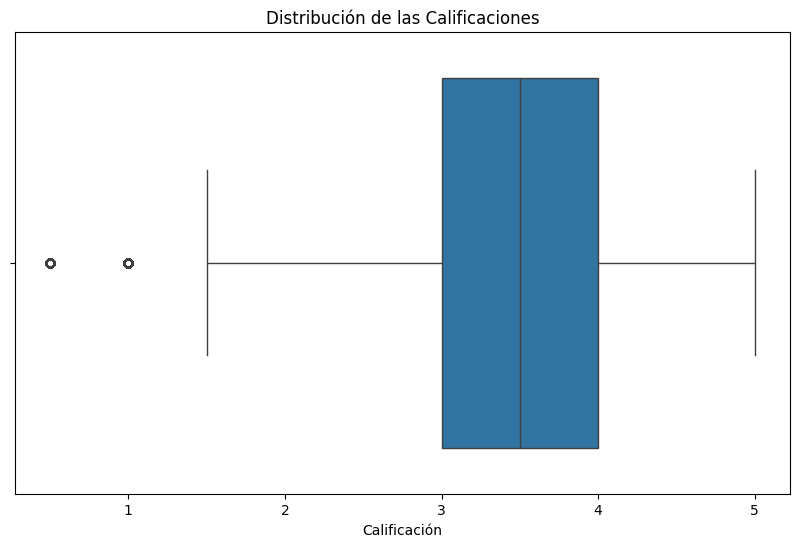

In [18]:
# Boxplot de la distribución de las calificaciones
plt.figure(figsize=(10,6))
sns.boxplot(x=df_ratings['rating'])
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.show()

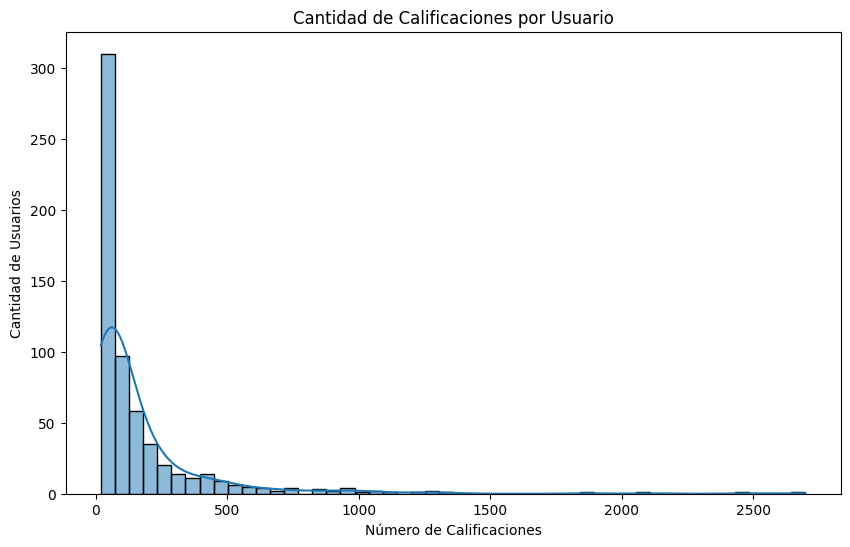

In [19]:
# Conteo de calificaciones por usuario
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

# Histograma de la cantidad de calificaciones por usuario
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title('Cantidad de Calificaciones por Usuario')
plt.xlabel('Número de Calificaciones')
plt.ylabel('Cantidad de Usuarios')
plt.show()

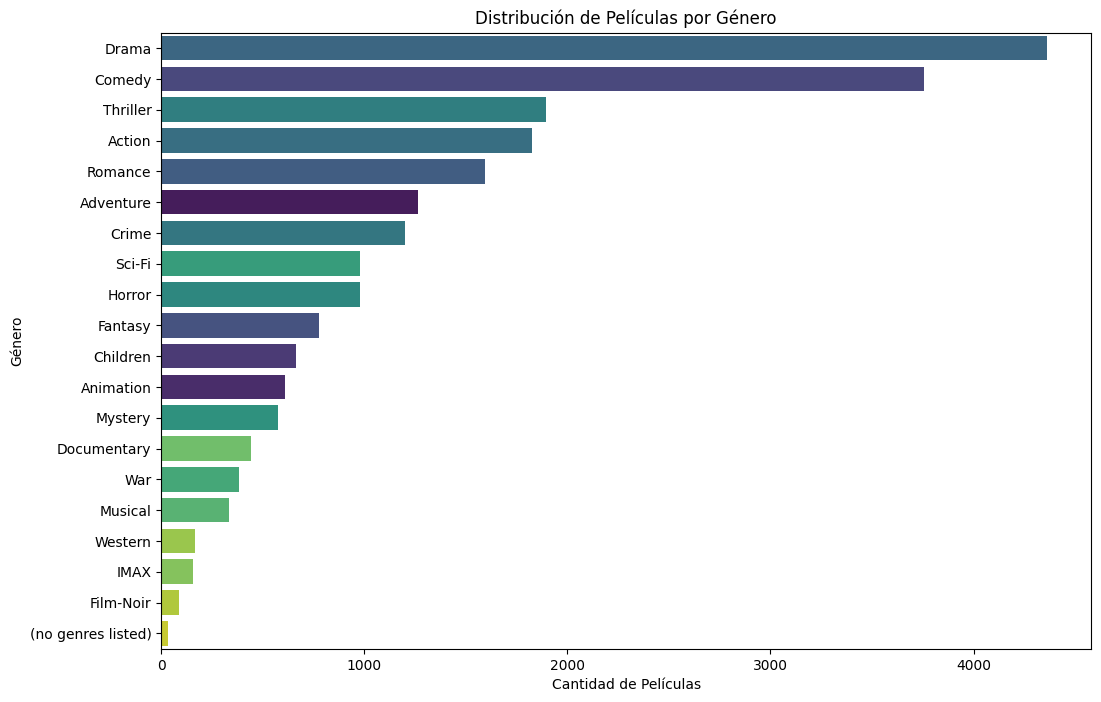

In [20]:
# Histograma de la Cantidad de Películas por Género
genres_exploded = df_movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
plt.figure(figsize=(12, 8))
sns.countplot(y=genres_exploded, order=genres_exploded.value_counts().index, hue=genres_exploded, dodge=False, palette='viridis', legend=False)
plt.title('Distribución de Películas por Género')
plt.xlabel('Cantidad de Películas')
plt.ylabel('Género')
plt.show()

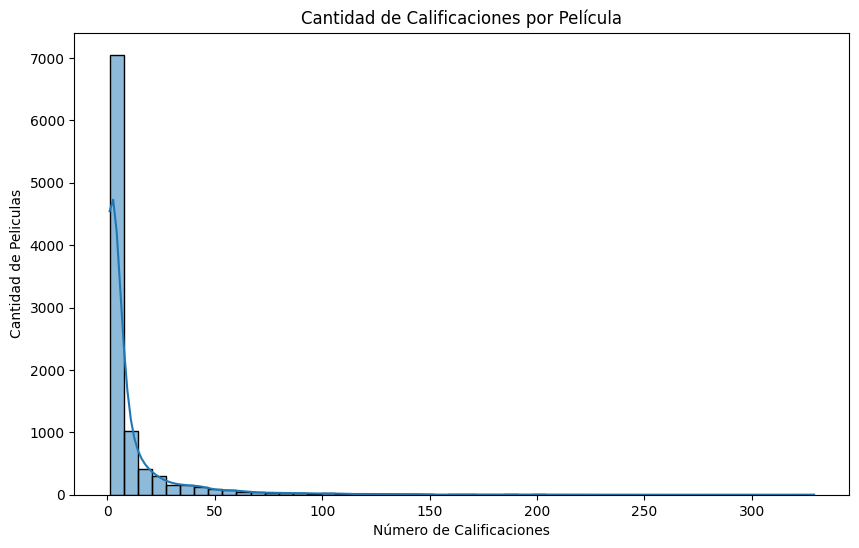

In [21]:
# Conteo de calificaciones por película
ratings_per_movie = df_ratings.groupby('movieId')['rating'].count()

# Histograma de la cantidad de calificaciones por película
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Cantidad de Calificaciones por Película')
plt.xlabel('Número de Calificaciones')
plt.ylabel('Cantidad de Peliculas')
plt.show()

In [22]:
# Total calificaciones por cada puntuación
df_ratings['rating'].value_counts()

,count
rating,
4.00,26818
3.00,20047
5.00,13211
3.50,13136
4.50,8551
2.00,7551
2.50,5550
1.00,2811
1.50,1791


# Creamos el DataFrame 'df_final'

In [23]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genres_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Children, Fantasy, Adventure, Animation, Comedy}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Children, Fantasy, Adventure, Animation, Comedy}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Children, Fantasy, Adventure, Animation, Comedy}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Children, Fantasy, Adventure, Animation, Comedy}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Children, Fantasy, Adventure, Animation, Comedy}"


In [31]:
def recomendaciones_populares():

  global df_final

  # Calculamos cuántas veces cada película ha sido votada
  movie_counts = df_final['title'].value_counts()

  # Filtramos las películas que tienen más de 210 votos
  df_popular_movies = df_final[df_final['title'].isin(movie_counts[movie_counts > 210].index)]

  # Agrupamos por título y calculamos el rating promedio de cada película
  df_grouped = df_popular_movies.groupby('title').agg(mean_rating=('rating', 'mean'), vote_count=('rating', 'count'))

  # Creamos un nuevo DataFrame df_movie_stats con las columnas mean_rating y vote_count
  df_movie_stats = df_grouped.reset_index()

  # Filtramos las 10 películas más votadas
  top_ten_movies = df_movie_stats.sort_values(by=['mean_rating', 'vote_count'], ascending=[False, False]).head(10)
  print(top_ten_movies)

top_movies = recomendaciones_populares()

                                                title  mean_rating  vote_count
7                    Shawshank Redemption, The (1994)         4.43         317
1                                   Fight Club (1999)         4.27         218
9           Star Wars: Episode IV - A New Hope (1977)         4.23         251
6                             Schindler's List (1993)         4.22         220
10  Star Wars: Episode V - The Empire Strikes Back...         4.22         211
5                                 Pulp Fiction (1994)         4.20         307
4                                  Matrix, The (1999)         4.19         278
2                                 Forrest Gump (1994)         4.16         329
8                    Silence of the Lambs, The (1991)         4.16         279
0                                   Braveheart (1995)         4.03         237


In [33]:
def recomendacion_ponderada():
  global df_final

  # Calculamos cuántas veces cada película ha sido votada
  vote_counts = df_final['title'].value_counts()

  # Filtramos películas con un número mínimo de votos (podemos ajustar el umbral según los datos)
  m = vote_counts.quantile(0.90)
  df_popular_movies = df_final[df_final['title'].isin(vote_counts[vote_counts >= m].index)]

  # Calculamos el rating promedio de cada película
  mean_ratings = df_popular_movies.groupby('title')['rating'].mean()

  # Creamos un nuevo DataFrame con las columnas mean_rating y vote_count
  df_movie_stats = pd.DataFrame({
      'mean_rating': mean_ratings,
      'vote_count': df_popular_movies.groupby('title')['rating'].count()
  })

  # Calculamos el promedio bayesiano ponderado
  C = df_movie_stats['mean_rating'].mean()
  df_movie_stats['weighted_score'] = (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m) * df_movie_stats['mean_rating']) + (m / (df_movie_stats['vote_count'] + m) * C)

  # Ordenamos las películas por la puntuación ponderada
  top_movies = df_movie_stats.sort_values('weighted_score', ascending=False).head(10)

  print(top_movies[['mean_rating', 'vote_count', 'weighted_score']])
  return top_movies[['mean_rating', 'vote_count', 'weighted_score']]

recomendacion_ponderada()


                                                    mean_rating  vote_count  \
title                                                                         
Shawshank Redemption, The (1994)                           4.43         317   
Godfather, The (1972)                                      4.29         192   
Fight Club (1999)                                          4.27         218   
Star Wars: Episode IV - A New Hope (1977)                  4.23         251   
Usual Suspects, The (1995)                                 4.24         204   
Schindler's List (1993)                                    4.22         220   
Pulp Fiction (1994)                                        4.20         307   
Star Wars: Episode V - The Empire Strikes Back ...         4.22         211   
Godfather: Part II, The (1974)                             4.26         129   
Matrix, The (1999)                                         4.19         278   

                                                   

,mean_rating,vote_count,weighted_score
title,,,
"Shawshank Redemption, The (1994)",4.43,317,4.36
"Godfather, The (1972)",4.29,192,4.20
Fight Club (1999),4.27,218,4.19
Star Wars: Episode IV - A New Hope (1977),4.23,251,4.17
"Usual Suspects, The (1995)",4.24,204,4.16
Schindler's List (1993),4.22,220,4.15
Pulp Fiction (1994),4.20,307,4.15
Star Wars: Episode V - The Empire Strikes Back (1980),4.22,211,4.14
"Godfather: Part II, The (1974)",4.26,129,4.14


In [34]:
def jaccard_similarity(set1, set2):
  intersiction = len(set1.intersection(set2))
  union = len(set1.union(set2))
  return intersiction / union

In [35]:
def recomendacion_jaccard(movie_title):
  movie_genre = df_final.set_index('title')['genre'].apply(lambda x: set(x.split))

In [36]:
def recomendacion_jaccard(movie_title):
    # Paso 1: Crear un diccionario que asocia cada película con su conjunto de géneros
    movie_genres = df_movies.set_index('title')['genres'].apply(lambda x: set(x.split('|'))).to_dict()

    # Paso 2: Obtener el conjunto de géneros de la película de entrada
    input_movie_genres = movie_genres.get(movie_title)

    if input_movie_genres is None:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None

    # Paso 3: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for title, genres in movie_genres.items():
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 4: Ordenar los ítems por su similitud de Jaccard
    similar_movies = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Paso 5: Imprimir y retornar las películas más similares según la similitud de Jaccard
    top_similar_movies = similar_movies[:10]
    print(f"Películas más similares a '{movie_title}' según la similitud de Jaccard:")
    for movie, similarity in top_similar_movies:
        print(f"{movie} - Similitud de Jaccard: {similarity:.2f}")

    return top_similar_movies

# Llamar a la función para ver el resultado
recomendacion_jaccard("Toy Story (1995)")

Películas más similares a 'Toy Story (1995)' según la similitud de Jaccard:
Antz (1998) - Similitud de Jaccard: 1.00
Toy Story 2 (1999) - Similitud de Jaccard: 1.00
Adventures of Rocky and Bullwinkle, The (2000) - Similitud de Jaccard: 1.00
Emperor's New Groove, The (2000) - Similitud de Jaccard: 1.00
Monsters, Inc. (2001) - Similitud de Jaccard: 1.00
Wild, The (2006) - Similitud de Jaccard: 1.00
Shrek the Third (2007) - Similitud de Jaccard: 1.00
Tale of Despereaux, The (2008) - Similitud de Jaccard: 1.00
Asterix and the Vikings (Astérix et les Vikings) (2006) - Similitud de Jaccard: 1.00
Turbo (2013) - Similitud de Jaccard: 1.00


[('Antz (1998)', 1.0),
 ('Toy Story 2 (1999)', 1.0),
 ('Adventures of Rocky and Bullwinkle, The (2000)', 1.0),
 ("Emperor's New Groove, The (2000)", 1.0),
 ('Monsters, Inc. (2001)', 1.0),
 ('Wild, The (2006)', 1.0),
 ('Shrek the Third (2007)', 1.0),
 ('Tale of Despereaux, The (2008)', 1.0),
 ('Asterix and the Vikings (Astérix et les Vikings) (2006)', 1.0),
 ('Turbo (2013)', 1.0)]

In [37]:
import pandas as pd

# Función para calcular la Similitud de Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Función de Recomendación basada en Similitud de Jaccard
def recomendacion_jaccard(movie_title):
    # Paso 1: Crear un diccionario que asocia cada película con su conjunto de géneros
    movie_genres = df_movies.set_index('title')['genres'].apply(lambda x: set(x.split('|'))).to_dict()

    # Paso 2: Obtener el conjunto de géneros de la película de entrada
    input_movie_genres = movie_genres.get(movie_title)

    if input_movie_genres is None:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None

    # Paso 3: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for title, genres in movie_genres.items():
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 4: Crear un DataFrame con las películas más similares según la similitud de Jaccard
    df_similar_movies = pd.DataFrame(list(similarities.items()), columns=['title', 'jaccard_similarity'])

    # Ordenar el DataFrame por la similitud de Jaccard en orden descendente
    df_similar_movies = df_similar_movies.sort_values(by='jaccard_similarity', ascending=False).head(10)

    return df_similar_movies

# Llamar a la función para ver el resultado en un DataFrame
df_recomendaciones_jaccard = recomendacion_jaccard("Toy Story (1995)")

In [30]:
df_recomendaciones_jaccard

,title,jaccard_similarity
2354,Toy Story 2 (1999),1.00
6192,"Wild, The (2006)",1.00
6945,"Tale of Despereaux, The (2008)",1.00
2808,"Adventures of Rocky and Bullwinkle, The (2000)",1.00
3567,"Monsters, Inc. (2001)",1.00
8216,Turbo (2013),1.00
9425,Moana (2016),1.00
1705,Antz (1998),1.00
2999,"Emperor's New Groove, The (2000)",1.00
7757,Asterix and the Vikings (Astérix et les Viking...,1.00


In [38]:
import pandas as pd

# Función para calcular la Similitud de Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Función de Recomendación basada en Similitud de Jaccard utilizando df_final
def recomendacion_jaccard(df_final, movie_title):
    # Paso 1: Filtrar el DataFrame para eliminar duplicados y trabajar solo con un título de película
    df_unique_movies = df_final.drop_duplicates(subset=['title'])

    # Paso 2: Obtener el conjunto de géneros de la película de entrada
    input_movie_genres = df_unique_movies[df_unique_movies['title'] == movie_title]['genres_set'].values
    if len(input_movie_genres) == 0:
        print(f"La película '{movie_title}' no se encuentra en el dataset.")
        return None
    input_movie_genres = input_movie_genres[0]

    # Paso 3: Calcular la similitud de Jaccard entre la película de entrada y todas las demás
    similarities = {}
    for index, row in df_unique_movies.iterrows():
        title = row['title']
        genres = row['genres_set']
        if title != movie_title:
            similarity = jaccard_similarity(input_movie_genres, genres)
            similarities[title] = similarity

    # Paso 4: Crear un DataFrame con las películas más similares según la similitud de Jaccard
    df_similar_movies = pd.DataFrame(list(similarities.items()), columns=['title', 'jaccard_similarity'])

    # Ordenar el DataFrame por la similitud de Jaccard en orden descendente
    df_similar_movies = df_similar_movies.sort_values(by='jaccard_similarity', ascending=False).head(10)

    return df_similar_movies

# Llamar a la función para ver el resultado en un DataFrame
df_recomendaciones_jaccard = recomendacion_jaccard(df_final, "Toy Story (1995)")
print(df_recomendaciones_jaccard)

                                                  title  jaccard_similarity
3856  Asterix and the Vikings (Astérix et les Viking...                1.00
7202                                   Wild, The (2006)                1.00
7891                                       Turbo (2013)                1.00
734                                  Toy Story 2 (1999)                1.00
4621                                       Moana (2016)                1.00
4190                     Tale of Despereaux, The (2008)                1.00
1801                   Emperor's New Groove, The (2000)                1.00
1591                                        Antz (1998)                1.00
1904                             Shrek the Third (2007)                1.00
1756     Adventures of Rocky and Bullwinkle, The (2000)                1.00
